# **Applying Bayesian Hierarchical Methods to MLB season Win Probabilties with PyStan**

For the 2024 season, I thought it would be a fun project to resample walks, strikeouts, and batted ball expected outcomes for each MLB game to determine who "should have" won a game. What does this mean? Well, if Team A has a substantial amount of barrels (i.e. hard-hit balls with optimal launch angles) more than Team B, then Team A should win more often than not. For example, if a batted ball has a 50% probability of being an out and a 50% chance of being a Single, then we can run 1000 simulations of a game and redistribute ~500 Outs and ~500 Singles throughout different at-bats. Of course, this assumes hits are randomly distributed throughout a game, so a sparse distribution of 9 Singles will likely not yield as many runs as 5 sequential Singles.

To predict batted ball outcomes, I use a Gradient Boosting Classifier model that uses exit velocity, launch angle, and stadium to predict the probabilities of an Out, Single, Double, Triple, and Home Run (if you'd like to learn more then, check out the GitHub repo https://github.com/dgrifka/baseball_game_simulator and Twitter bot https://x.com/mlb_simulator). Let's see if we can use 2024's win probabilities for each game to determine each team's *true* win probability for the season.

A 162 game season is long. It's reasonable to assume that each team's end-of-season win percentage is their true win probability. But baseball is random! How random? Well, that's what we're trying to determine.

The model mentioned above has an outcome accuracy of 77%, but when the expected outcomes are resampled, we can correctly determine who "should have" won a game about 78% of the time. I've received suggestions on how to improve the efficacy of the model, including incorporating spray angle, errors, and steals, but I plan to work on this in the offseason.

Ok, so what is each team's *true* win probability? In Bayesian statistics, we don't know, but we try our best to estimate them. One way to approach this is by using a Bayesian hierarchical model, which "pools" information across groups (in this case, teams), so that we can create more robust estimates for each team by sharing league-wide effects. For example, the model will likely be skeptical of the White Sox's 25% win percentage, since this is very unlikely to happen, in general.

Admittedly, this is a rather simple exercise and doesn't necessarily warrant a hierarchical model, but I wanted to sharpen my Bayesian hierarchical modeling capabilities and utilize a popular probabilistic programming language (PPL), Stan, and its Python interface, PyStan. However, the benefit of using a PPL is that we can receive a posterior distribution of the parameters. In other words, we can quantify our uncertainty of each parameter. In this case, the main parameter of interest is win probability.

First, we're going to use the Polars package, instead of Pandas, since it's faster. To do this, we have to make sure it's installed in our environment.

In [ ]:
%pip install polars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 37.8 MB/s eta 0:00:00


Then, we're going to read in the each game's win probabilities calculated by our model this year.

Note: Since stadium is a feature in the model, win probabilities are only calculated for regular season games played in the standard 30 ballparks. In other words, games played in South Korea and Williamsport are not included in this analysis.

In [ ]:
import polars as pl
## Read in historical_wp.csv with polars
historical_wp = pl.read_csv("historical_wp.csv")
## Remove 2024 playoff games
historical_wp = historical_wp.filter(pl.col("date") < "2024-10-01")
## Remove duplicate gamePk values to be safe
historical_wp = historical_wp.unique(subset="gamePk")
## Sort date asc
historical_wp = historical_wp.sort("date")
historical_wp.head()

home,away,gamePk,date,home_score,away_score,home_wp,away_wp
str,str,i64,str,i64,i64,str,str
"""Astros""","""Yankees""",746418,"""2024-03-28""",4,5,"""56%""","""34%"""
"""Dodgers""","""Cardinals""",746165,"""2024-03-28""",7,1,"""74%""","""17%"""
"""Royals""","""Twins""",746335,"""2024-03-28""",1,4,"""24%""","""68%"""
"""Reds""","""Nationals""",746737,"""2024-03-28""",8,2,"""89%""","""6%"""
"""Padres""","""Giants""",745445,"""2024-03-28""",6,4,"""19%""","""68%"""


To prepare the code for the Stan model (note: we'll be using PyStan to interact with Stan from this environment), we need to do some housekeeping. We need to convert the win probabilities from strings to floats.

As a note, when batted ball outcomes are resampled, there's a possibility that the simulation ends in a tie, which is obviously impossible in a real game. To account for this, we're going to assign half of the tie probability to each team (example: Team A wp = 60%, Team B wp = 30%, Tie p = 10%. We want to convert this to Team A wp = 65%, Team B wp = 35%).

Additionally, these win probabilites are rounded, so if Team A's win probability is 99.5%, then the values appears as 100%. However, values of 0% and 100% can cause issues in statistical models, so I'm going to add/subtract tiny values to prevent exactly 0% and 100%.

In [ ]:
## Function to convert percentage string to decimal
def percentage_to_decimal(s):
    return pl.col(s).str.replace('%', '').cast(pl.Float64) / 100

## Add tie_wp column, then redistribute it to home_wp and away_wp
historical_wp_cleaned = historical_wp.with_columns([
    percentage_to_decimal('home_wp').alias('home_wp_decimal'),
    percentage_to_decimal('away_wp').alias('away_wp_decimal'),
    (1 - (percentage_to_decimal('home_wp') + percentage_to_decimal('away_wp'))).alias('tie_wp')
]).with_columns([
    (pl.col('home_wp_decimal') + 0.5 * pl.col('tie_wp')).alias('home_wp_adjusted'),
    (pl.col('away_wp_decimal') + 0.5 * pl.col('tie_wp')).alias('away_wp_adjusted')
])

## Adjust values that are exactly 0 or 1
historical_wp_cleaned = historical_wp_cleaned.with_columns([
    pl.when(pl.col('home_wp_adjusted') == 0)
    .then(0.0001)
    .when(pl.col('home_wp_adjusted') == 1)
    .then(0.9999)
    .otherwise(pl.col('home_wp_adjusted'))
    .alias('home_wp_adjusted'),

    pl.when(pl.col('away_wp_adjusted') == 0)
    .then(0.0001)
    .when(pl.col('away_wp_adjusted') == 1)
    .then(0.9999)
    .otherwise(pl.col('away_wp_adjusted'))
    .alias('away_wp_adjusted')
])

historical_wp_cleaned

home,away,gamePk,date,home_score,away_score,home_wp,away_wp,home_wp_decimal,away_wp_decimal,tie_wp,home_wp_adjusted,away_wp_adjusted
str,str,i64,str,i64,i64,str,str,f64,f64,f64,f64,f64
"""Astros""","""Yankees""",746418,"""2024-03-28""",4,5,"""56%""","""34%""",0.56,0.34,0.1,0.61,0.39
"""Dodgers""","""Cardinals""",746165,"""2024-03-28""",7,1,"""74%""","""17%""",0.74,0.17,0.09,0.785,0.215
"""Royals""","""Twins""",746335,"""2024-03-28""",1,4,"""24%""","""68%""",0.24,0.68,0.08,0.28,0.72
"""Reds""","""Nationals""",746737,"""2024-03-28""",8,2,"""89%""","""6%""",0.89,0.06,0.05,0.915,0.085
"""Padres""","""Giants""",745445,"""2024-03-28""",6,4,"""19%""","""68%""",0.19,0.68,0.13,0.255,0.745
…,…,…,…,…,…,…,…,…,…,…,…,…
"""Giants""","""Cardinals""",745282,"""2024-09-29""",1,6,"""47%""","""37%""",0.47,0.37,0.16,0.55,0.45
"""Brewers""","""Mets""",745932,"""2024-09-29""",0,5,"""6%""","""86%""",0.06,0.86,0.08,0.1,0.9
"""D-backs""","""Padres""",747147,"""2024-09-29""",11,2,"""100%""","""0%""",1.0,0.0,0.0,0.9999,0.0001


For the model, we'd like to have 1 row for each team and game.

In [ ]:
## Create a dataframe for home teams
home_df = historical_wp_cleaned.select([
    pl.col('home').alias('team'),
    'gamePk',
    'date',
    pl.col('home_score').alias('score'),
    pl.col('home_wp_adjusted').alias('win_probability')
])

## Create a dataframe for away teams
away_df = historical_wp_cleaned.select([
    pl.col('away').alias('team'),
    'gamePk',
    'date',
    pl.col('away_score').alias('score'),
    pl.col('away_wp_adjusted').alias('win_probability')
])

## Concatenate the two dataframes
combined_df = pl.concat([home_df, away_df])

## Sort the result
team_wp = combined_df.sort(['date', 'gamePk', 'team'])

## Convert date to Date type
team_wp = team_wp.with_columns(
    pl.col("date").str.strptime(pl.Date, format="%Y-%m-%d")
)

# Display the result
team_wp

team,gamePk,date,score,win_probability
str,i64,date,i64,f64
"""Cubs""",745039,2024-03-28,3,0.31
"""Rangers""",745039,2024-03-28,4,0.69
"""Blue Jays""",745116,2024-03-28,8,0.915
"""Rays""",745116,2024-03-28,2,0.085
"""Mariners""",745283,2024-03-28,4,0.38
…,…,…,…,…
"""Padres""",747147,2024-09-29,2,0.0001
"""Braves""",747064,2024-09-30,3,0.845
"""Mets""",747064,2024-09-30,0,0.155


Before we begin modeling, we should get a better understanding of our data by plotting a binned histogram of all win probabilites.

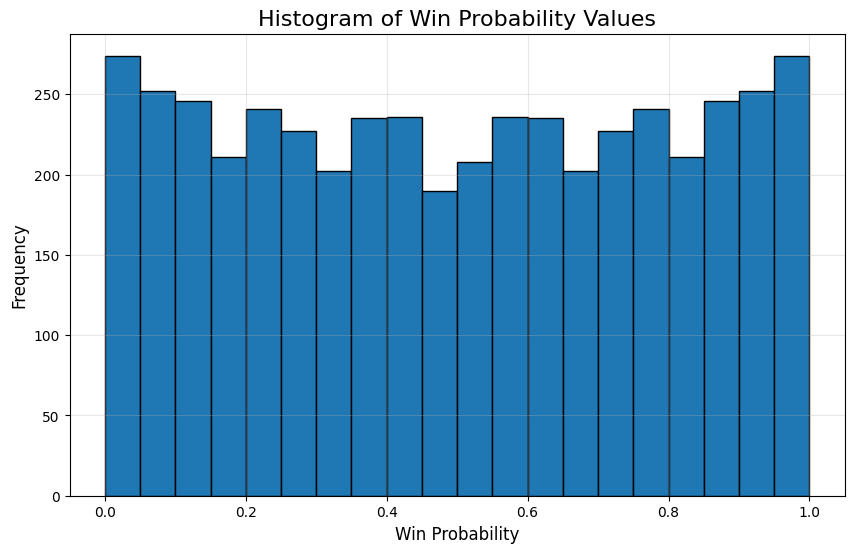

In [ ]:
import matplotlib.pyplot as plt

# Extract the win_probability column as a numpy array
win_prob_values = team_wp['win_probability'].to_numpy()

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(win_prob_values, bins=20, edgecolor='black')

# Customize the plot
plt.title('Histogram of Win Probability Values', fontsize=16)
plt.xlabel('Win Probability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

Interesting! Using all win probabilities calculated by the model, they appear quite uniform in nature, which suggests that when using batted ball metrics, games are not more likely to be 50/50 than any other outcome. This intuitively makes sense, but we see that towards the extremes, 0% and 100%, are a little more likely than the other outcomes. This is likely a result of games that are blowouts that can get out of hand if a team decides to put position players on the mound, for example. For our purposes, we'er going to assume this is approximately uniform.

So, how can we incorporate this prior information about win probabilities into a model? There are a few ways to do this, but I'm going to share the methodology below with a help from a package called PreliZ (https://preliz.readthedocs.io/en/latest/index.html). Please note that choosing this prior distribution took some trial and error, but I'll do my best to explain my choice. I like using PreliZ because it has an array of options to help us model the distribution of our underlying data, but essentially I'm attempting to create a distribution that largely mimics the actual win probability distribution that we saw this year.

In [ ]:
%pip install preliz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 176.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.9/509.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 35.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


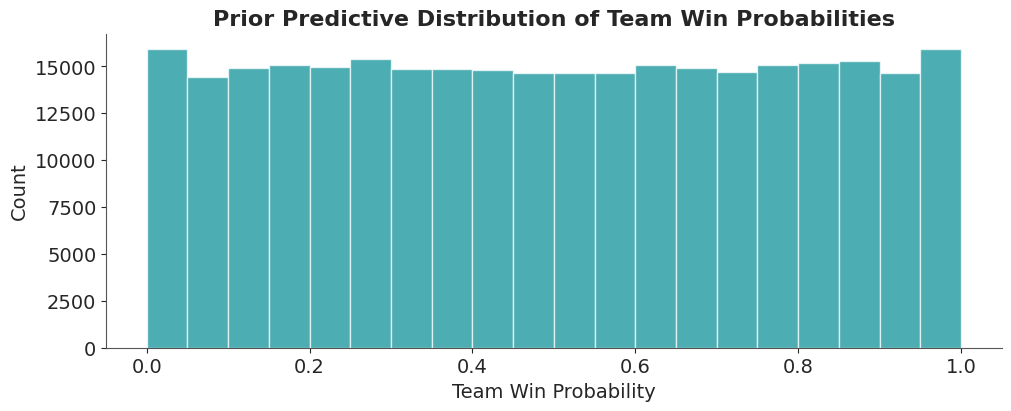

In [ ]:
import preliz as pz
import numpy as np

pz.style.library["preliz-doc"]["figure.dpi"] = 100
pz.style.library["preliz-doc"]["figure.figsize"] = (10, 4)
pz.style.use("preliz-doc")

def stan_preliz_model():
    ## Priors
    mu_global = pz.Normal(0, 1.2).rvs(30)
    tau_global = pz.InverseGamma(2.5, 1).rvs(30)
    mu_raw = pz.Normal(0, 1).rvs(30)
    sigma = pz.InverseGamma(2, 1).rvs(30)

    ## Transform raw parameters
    mu = mu_global + tau_global * mu_raw

    ## Generate logit win probabilities
    logit_win_probability = pz.Normal(mu, sigma).rvs(30)

    ## Transform logit to probability
    win_probability = 1 / (1 + np.exp(-logit_win_probability))

    return win_probability

## Function to plot a histogram
def custom_hist(predictions, ax):
    ax.hist(predictions.flatten(), bins=20, alpha=0.7)
    ax.set_xlabel('Team Win Probability')
    ax.set_ylabel('Count')
    ax.set_title('Prior Predictive Distribution of Team Win Probabilities')

## Plot prior predictive distribution
pz.predictive_explorer(stan_preliz_model, samples=10000, plot_func=custom_hist)
plt.show()

Since we're creating a hierarchical model, the global parameters, mu_global and tau_global, provide an overall structure, while the team-specific parameter, mu_raw, allows for individual team differences.

We then convert the logit probabilities to actual probabilities (i.e. between 0 and 1) using the logistic function. If you'd like to learn more about log odds and the logit function, then I recommend this article, https://www.statisticshowto.com/log-odds/, since I found it very helpful.

The code then generates samples from this prior model to visualize what kind of win probabilities we might expect before seeing any actual data.

A neat aspect about PreliZ is that  Some Python packages, such as PyMC, allow you to input your priors directly from PreliZ!

Now, this is just our *prior* belief about any game's win probabilities before seeing any data. Before incorporating the data into the model, let's just take a look at win probability distributions between 2 teams: the Braves and the White Sox.

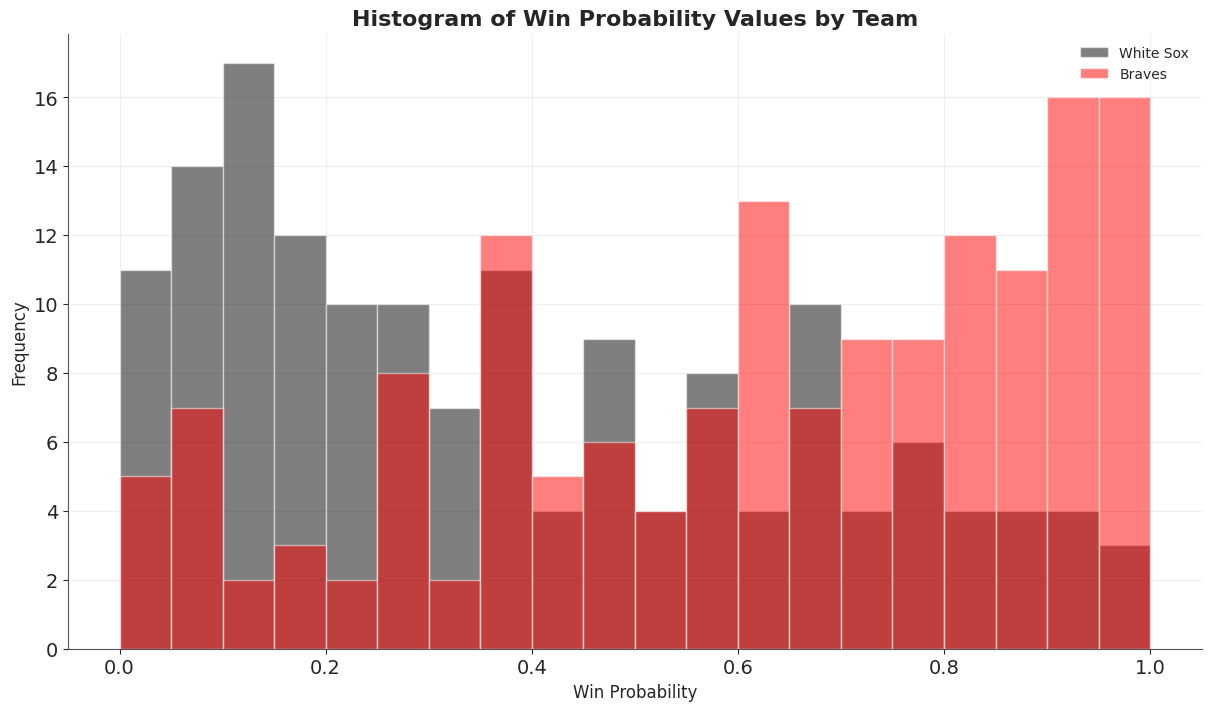

In [ ]:
## Extract win probabilities for each team
white_sox_wp = team_wp.filter(pl.col('team') == 'White Sox')['win_probability'].to_numpy()
braves_wp = team_wp.filter(pl.col('team') == 'Braves')['win_probability'].to_numpy()

## Create the histogram
plt.figure(figsize=(12, 7))

## Define the number of bins and range
bins = np.linspace(0, 1, 21)  # 20 bins from 0 to 1

## Plot histograms for both teams
plt.hist(white_sox_wp, bins=bins, alpha=0.5, color='black', label='White Sox', edgecolor='white')
plt.hist(braves_wp, bins=bins, alpha=0.5, color='red', label='Braves', edgecolor='white')

## Customize the plot
plt.title('Histogram of Win Probability Values by Team', fontsize=16)
plt.xlabel('Win Probability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

## Show the plot
plt.show()

It's clear that the White Sox have experienced lower win probabilities (duh), on average, than the Braves. So, we start with our prior belief that win probabilities are uniform, but now we update this belief with our data. To do this, we have to make sure we have pystan installed.

In [ ]:
%pip install pystan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.9/447.9 kB 31.2 MB/s eta 0:00:00


When coding in Stan, it's imperative that we work in lists vs. DataFrames. To model the group-level effects, we make sure to create a list of teams. Then, we prepare the data dictionary that will be inputted into the model:

*   N = number of observations (i.e. games)
*   T = number of teams
*   team: team indices corresponding to each row in the DataFrame
*   win_probability = array of probabilities

The epsilon applies a small correction to the win probabilities to avoid extreme values of 0 or 1.

In [ ]:
def prepare_data(df):
    teams = df['team'].unique().to_list()
    team_to_index = {team: i+1 for i, team in enumerate(teams)}

    ## Apply a small correction to 0 and 1 probabilities to avoid infinite logits
    epsilon = 1e-6
    win_probability = np.clip(df['win_probability'], epsilon, 1 - epsilon)

    data = {
        'N': len(df),
        'T': len(teams),
        'team': [team_to_index[t] for t in df['team']],
        'win_probability': win_probability
    }
    return data, teams

Now, the fun part! Let's create the Stan model.

For efficiency, it's common practice to set constraints for variables by specifying "lower" or "upper", as shown below. For example, the number of teams (30 MLB teams) can't be a negative number, so we declare it an integer with a lower value of 0, which gives Stan a constrained parameter space to estimate.

Then, we're going to implement the prior distribution information from above into our parameters and model, then calculate the estimated win probabilities for each team.

Here is the statistical notation of our Stan model:

# **Data**

N: Number of observations

T: Number of teams

team[i] ∈ {1, ..., T}: Team index for each observation i

win_probability[i] ∈ (0, 1): Observed win probabilities

# **Transformed Data**

logit_win_probability[i] = logit(win_probability[i])

# **Parameters**

μ_global ~ N(0, 1.2)

τ_global ~ N(2.5, 1)

μ_raw[t] ~ N(0, 1)

σ_raw[t] ~ N(2, 1)

# **Transformed Parameters**

μ[t] = μ_global + τ_global * μ_raw[t], for t = 1, ..., T

σ[t] = σ_raw[t] + 0.01, for t = 1, ..., T

# **Model**

logit_win_probability[i] ~ N(μ[team[i]], σ[team[i]]), for i = 1, ..., N

# **Generated Quantities**

team_win_prob[t] = inv_logit(μ[t]), for t = 1, ..., T

In [ ]:
import stan

## Stan model
stan_code = """
data {
  int<lower=0> N;
  int<lower=0> T;
  array[N] int<lower=1, upper=T> team;
  vector<lower=0, upper=1>[N] win_probability;
}

transformed data {
  vector[N] logit_win_probability = logit(win_probability);
}

parameters {
  real mu_global;
  real<lower=0> tau_global;
  vector[T] mu_raw;
  vector<lower=0>[T] sigma_raw;
}

transformed parameters {
  vector[T] mu = mu_global + tau_global * mu_raw;
  vector<lower=0>[T] sigma = sigma_raw + 0.01;  // Adding a small constant
}

model {
  // Priors
  mu_global ~ normal(0, 1.2);
  tau_global ~ normal(2.5, 1);
  mu_raw ~ normal(0, 1);
  sigma_raw ~ normal(2, 1);

  // Likelihood
  for (n in 1:N) {
    logit_win_probability[n] ~ normal(mu[team[n]], sigma[team[n]]);
  }
}

generated quantities {
  vector<lower=0, upper=1>[T] team_win_prob;
  for (t in 1:T) {
    team_win_prob[t] = inv_logit(mu[t]);
  }
}
"""

Let's put the model to work.

Note: We're going ot use nest_asyncio, since it allows Stan to use its own event loop for sampling, even if this code is running in Google Colab that already has an event loop.

In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
## Prepare data
stan_data, teams = prepare_data(team_wp)

## Build and sample from the model
posterior = stan.build(stan_code, data=stan_data, random_seed=1)
fit = posterior.sample(num_chains=4, num_samples=1000)

## Extract results
df_results = fit.to_frame()

Building...



Building: 30.1s, done.Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  

The model appears to have run well without any major issues! Now, let's check on the model's performance.

In [ ]:
%pip install arviz

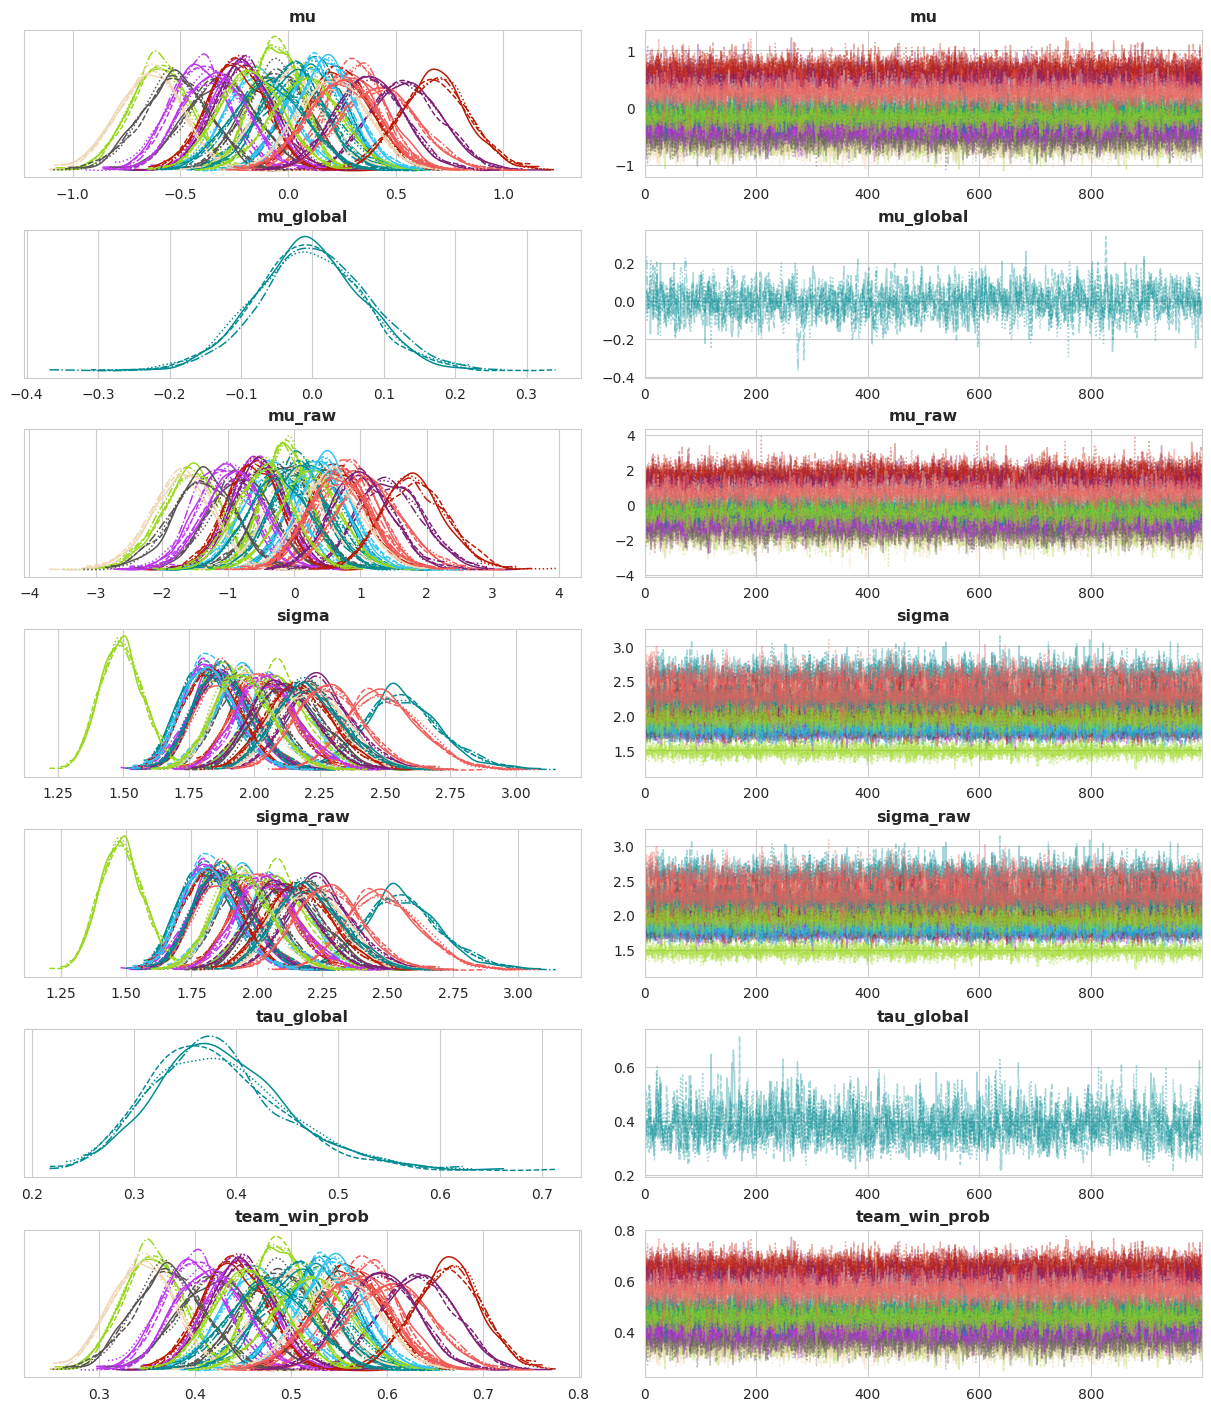

In [ ]:
import arviz as az

inf_data = az.from_pystan(posterior=fit)

az.plot_trace(inf_data)
plt.show()

These plots above for the parameters are called trace plots, which assess the performance and convergence of statistical models. Without getting into the weeds, these trace plots suggest generally good performance of the Stan model. Most parameters show good mixing and convergence across chains, indicated by the overlapping lines of different colors in the right-side plots.

Now, based on batted balls and walks, what does our model think about the White Sox and Braves *true* win percentages this year?

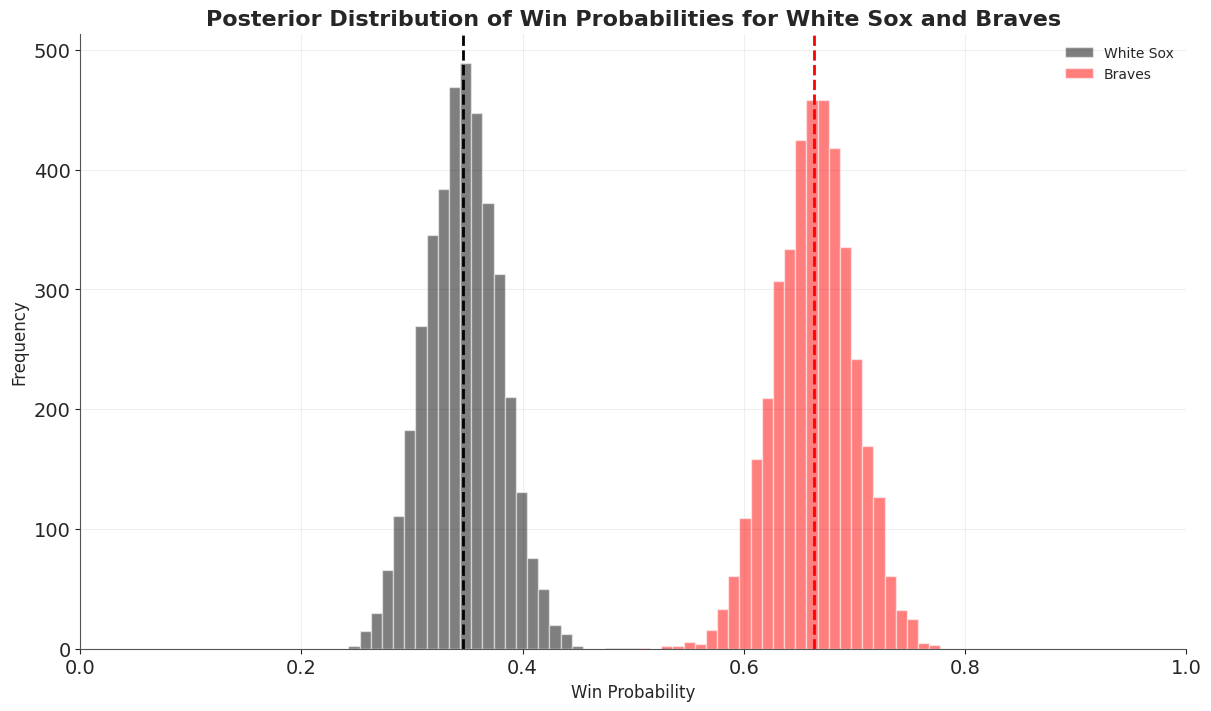

In [ ]:
import pandas as pd

## Find the indices of 'White Sox' and 'Braves' in the teams list
white_sox_index = teams.index('White Sox')
braves_index = teams.index('Braves')

## Extract the relevant columns for White Sox and Braves
white_sox_win_prob = df_results[f'team_win_prob.{white_sox_index + 1}']
braves_win_prob = df_results[f'team_win_prob.{braves_index + 1}']

## Create the plot
plt.figure(figsize=(12, 7))

## Define the number of bins and range
bins = np.linspace(0, 1, 100)

## Plot histograms for both teams
plt.hist(white_sox_win_prob, bins=bins, alpha=0.5, color='black', label='White Sox', edgecolor='white')
plt.hist(braves_win_prob, bins=bins, alpha=0.5, color='red', label='Braves', edgecolor='white')

plt.title("Posterior Distribution of Win Probabilities for White Sox and Braves", fontsize=16)
plt.xlabel("Win Probability", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, alpha=0.3)

## Add vertical lines for means
white_sox_mean = white_sox_win_prob.mean()
braves_mean = braves_win_prob.mean()
plt.axvline(white_sox_mean, color='black', linestyle='dashed', linewidth=2)
plt.axvline(braves_mean, color='red', linestyle='dashed', linewidth=2)

## Set x-axis limits between 0 and 1
plt.xlim(0, 1)
plt.legend(fontsize=10)

## Show the plot
plt.show()

Well, our model believes the Braves should have a win percentage 30% higher than the White Sox. Reasonable! Let's take a look at all teams.

In [ ]:
## Prepare the data
team_names = teams
num_teams = len(team_names)

## Create a new DataFrame for plotting
plot_data = []
for i, team in enumerate(team_names):
    col_name = f'team_win_prob.{i+1}'
    team_data = df_results[col_name].to_list()
    plot_data.extend([(team, wp) for wp in team_data])

plot_df = pd.DataFrame(plot_data, columns=['team', 'win_probability'])

## Calculate summary statistics
summary_df = plot_df.groupby('team').agg({
    'win_probability': ['mean', lambda x: x.quantile(0.025), lambda x: x.quantile(0.975)]
}).reset_index()
summary_df.columns = ['team', 'mean_win_probability', 'low', 'high']
summary_df = summary_df.sort_values('mean_win_probability', ascending=False)
summary_df

,team,mean_win_probability,low,high
4,Braves,0.663013,0.592196,0.729975
29,Yankees,0.632086,0.557578,0.704926
9,Dodgers,0.603827,0.522894,0.685355
12,Mariners,0.592941,0.518070,0.666222
1,Astros,0.576815,0.506722,0.644279
14,Mets,0.564187,0.488887,0.637850
18,Phillies,0.561984,0.480447,0.638910
16,Orioles,0.559436,0.486443,0.630364
17,Padres,0.551767,0.472154,0.627672
26,Tigers,0.544469,0.479214,0.612731


This is good, but let's create a visualization of the win probabilities and their credible intervals.

In [ ]:
## Import team colors to make the plot easier to read
team_colors = {
    "D-backs": "#A71930",
    "Braves": "#CE1141",
    "Orioles": "#DF4601",
    "Red Sox": "#BD3039",
    "White Sox": "#27251F",
    "Cubs": "#0E3386",
    "Reds": "#C6011F",
    "Guardians": "#00385D",
    "Rockies": "#333366",
    "Tigers": "#0C2C56",
    "Astros": "#EB6E1F",
    "Royals": "#004687",
    "Angels": "#BA0021",
    "Dodgers": "#005A9C",
    "Marlins": "#00A3E0",
    "Brewers": "#FFC52f",
    "Twins": "#002B5C",
    "Yankees": "#003087",
    "Mets": "#002D72",
    "Athletics": "#003831",
    "Phillies": "#E81828",
    "Pirates": "#FDB827",
    "Padres": "#2F241D",
    "Giants": "#FD5A1E",
    "Mariners": "#0C2C56",
    "Cardinals": "#C41E3A",
    "Rays": "#092C5C",
    "Rangers": "#C0111F",
    "Blue Jays": "#134A8E",
    "Nationals": "#AB0003",
    "NL": "#87CEEB",
    "AL": "#FF7F50"
}

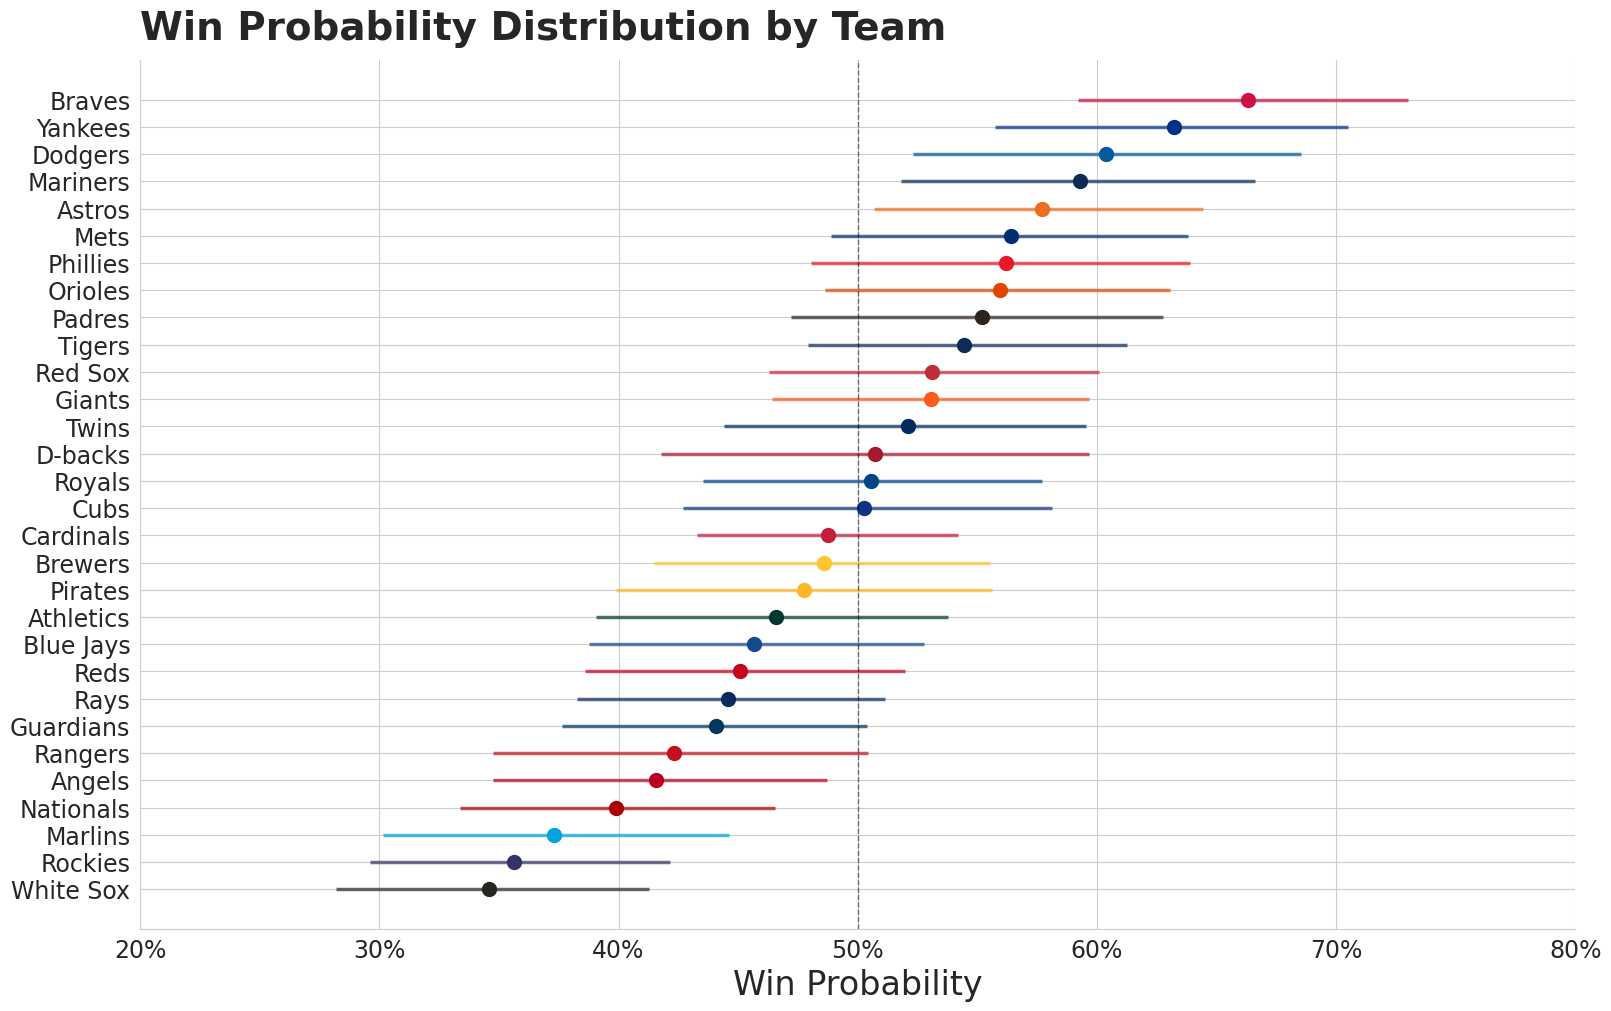

In [ ]:
import seaborn as sns

## Set up plot with highest win probabilities at the top
summary_df = summary_df.sort_values('mean_win_probability', ascending=True)

plt.figure(figsize=(16, 10))
sns.set_style("whitegrid")

## Plot points for win probabilities and intervals with team colors
for i, (_, row) in enumerate(summary_df.iterrows()):
    team_color = team_colors.get(row['team'], '#000000')
    plt.scatter(row['mean_win_probability'], row['team'], color=team_color, s=100)
    plt.hlines(row['team'], row['low'], row['high'], colors=team_color, linewidth=2.5, alpha=0.7)

## Add vertical dashed line at x = 0.5
plt.axvline(x=0.5, color='black', linestyle='--', linewidth=1, alpha = 0.5)

## Customize the labels
plt.xlabel('Win Probability', fontsize=24)
plt.title('Win Probability Distribution by Team', fontsize=28, loc='left', pad=15, fontweight='bold')

## Set x-axis limits
plt.xlim(0.2, 0.8)

## Convert x-axis labels to percentages
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.0%}"))

## Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

## Increase tick label size
plt.tick_params(axis='both', which='major', labelsize=17)

plt.show()

Interpreting this graph, we can say that using our batted ball outcome model, we're about 95% confident that the Braves' *true* win percentage is between 59% and 73%. What was their actual win probability at the end of the season? 55%, which is out of the model's 95% credible range.

Why is there so much uncertainty in our model's credible intervals? Well, estimating a team's win percentage using hit probabilities isn't easy, but also win probabilities can vary wildly from game to game. For example, the White Sox ended the season with a win percentage of 25%, but they had 7 games with a win probability >90%! With more data, the model will converge to the true mean, but this is just an example how random each baseball game can be.

So, the Braves predictions were outside our credible interval. Is our hit probability model bad? It's likely that there are additional factors, such as defensive fielding and spray angle not being accounted for, but our model suggests that the Braves underperformed compared to what their exit velocities and launch angles would suggest. So, is this an outlier? Well, let's see how accurate our model really is!

We start by calculating each team's actual win percentage for the games we've modeled this year. Then, merge them back onto our model's projections.

In [ ]:
actual_win_percentage = historical_wp.with_columns([
    pl.when(pl.col("home_score") > pl.col("away_score")).then(1).otherwise(0).alias("home_win"),
    pl.when(pl.col("away_score") > pl.col("home_score")).then(1).otherwise(0).alias("away_win")
])

## Create a dataframe for home teams
home_df = actual_win_percentage.select([
    pl.col('home').alias('team'),
    'gamePk',
    'date',
    pl.col('home_win').alias('win'),
])

## Create a dataframe for away teams
away_df = actual_win_percentage.select([
    pl.col('away').alias('team'),
    'gamePk',
    'date',
    pl.col('away_win').alias('win'),
])

## Concatenate the two dataframes
combined_df_actuals = pl.concat([home_df, away_df])

## Sum the number of wins and number of games for each team
combined_df_actuals = combined_df_actuals.group_by('team').agg([
    pl.col('win').sum().alias('wins'),
    pl.len().alias('count')
])

## Calculate win percentage
combined_df_actuals = combined_df_actuals.with_columns(
    (pl.col('wins') / pl.col('count')).alias('actual_win_percentage')

)

## Convert pandas DataFrame to polars DataFrame
summary_df_polars = pl.from_pandas(summary_df)

## Join estimates onto actuals
result_df_actual = combined_df_actuals.join(
    summary_df_polars,
    on="team",
    how="left"
)

## Then, we calculate the difference between estimates and actuals
result_df_actual = result_df_actual.with_columns([
    (pl.col("actual_win_percentage") - pl.col("mean_win_probability")).alias("diff_mean"),
    (pl.col("actual_win_percentage") - pl.col("low")).alias("diff_low"),
    (pl.col("actual_win_percentage") - pl.col("high")).alias("diff_high")
])

result_df_actual

team,wins,count,actual_win_percentage,mean_win_probability,low,high,diff_mean,diff_low,diff_high
str,i32,u32,f64,f64,f64,f64,f64,f64,f64
"""Royals""",83,156,0.532051,0.505412,0.435432,0.577067,0.026639,0.09662,-0.045015
"""Tigers""",83,155,0.535484,0.544469,0.479214,0.612731,-0.008985,0.05627,-0.077247
"""Rangers""",74,156,0.474359,0.423343,0.347561,0.504398,0.051016,0.126798,-0.030039
"""White Sox""",39,156,0.25,0.345901,0.281706,0.412548,-0.095901,-0.031706,-0.162548
"""Nationals""",67,155,0.432258,0.398875,0.333808,0.465331,0.033383,0.09845,-0.033072
…,…,…,…,…,…,…,…,…,…
"""Mets""",86,153,0.562092,0.564187,0.488887,0.63785,-0.002095,0.073205,-0.075759
"""Yankees""",90,154,0.584416,0.632086,0.557578,0.704926,-0.047671,0.026838,-0.120511
"""Cardinals""",80,155,0.516129,0.487366,0.432605,0.541805,0.028763,0.083524,-0.025676


Then, we plot.

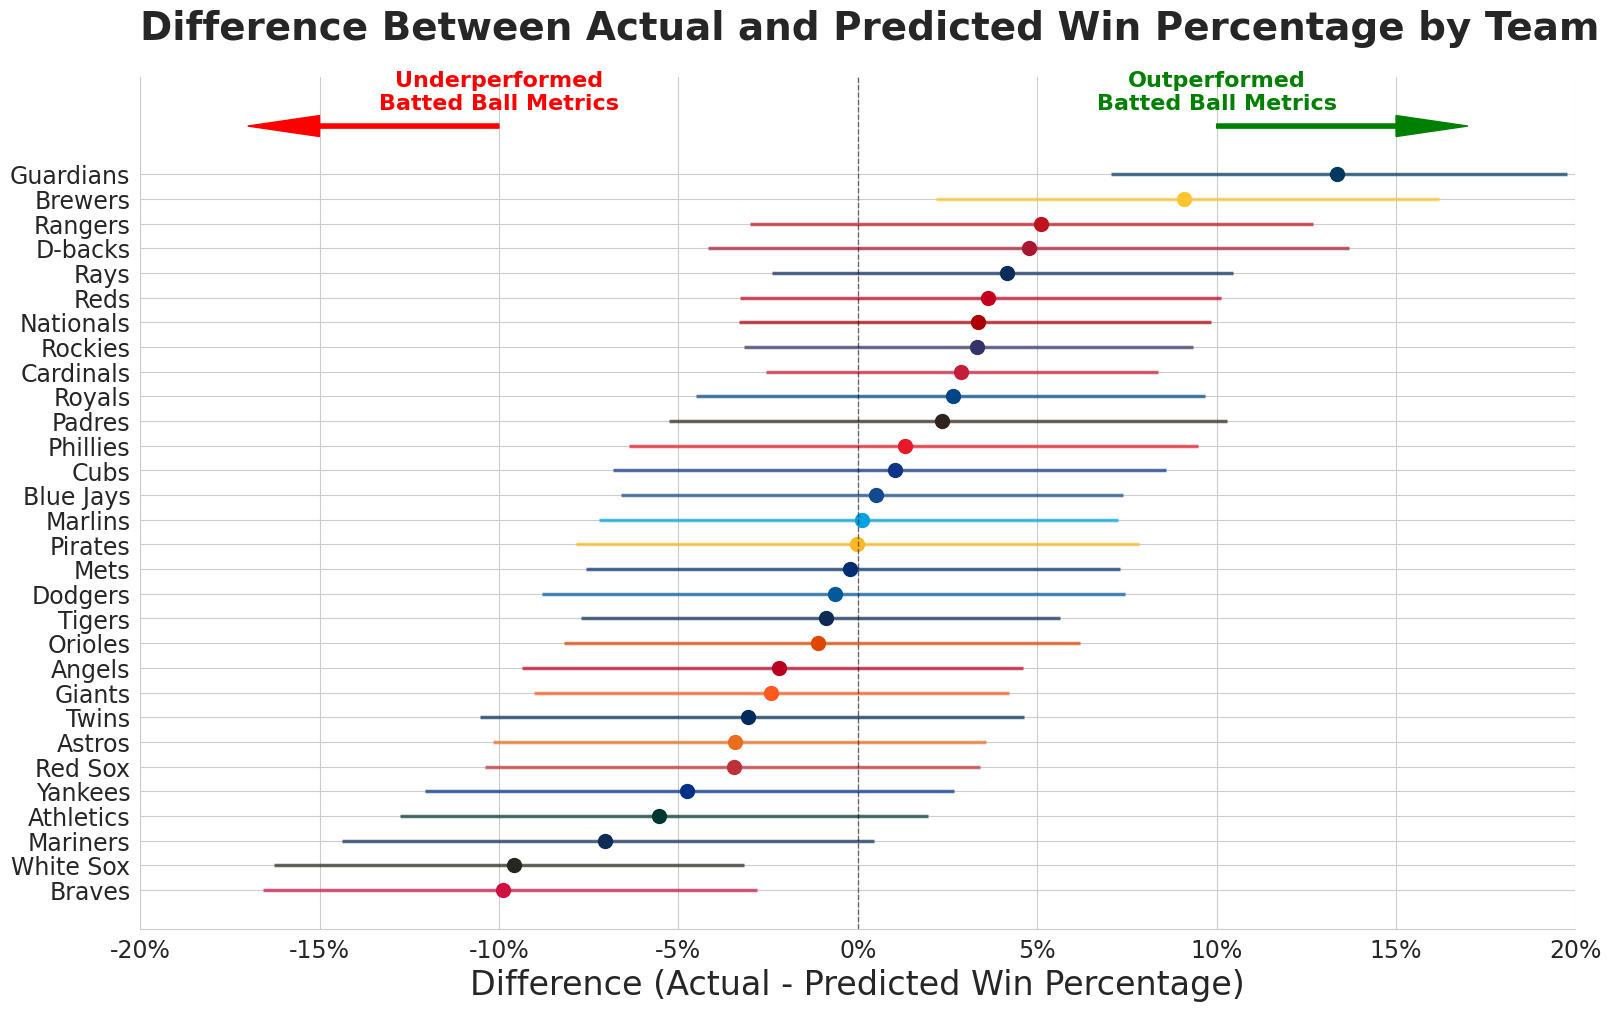

In [ ]:
# Convert polars DataFrame to pandas for easier plotting with seaborn
plot_df = result_df_actual.sort("diff_mean").to_pandas()

plt.figure(figsize=(16, 10))
sns.set_style("whitegrid")

# Plot points for win probability differences and intervals with team colors
for i, (_, row) in enumerate(plot_df.iterrows()):
    team_color = team_colors.get(row['team'], '#000000')
    plt.scatter(row['diff_mean'], row['team'], color=team_color, s=100)
    plt.hlines(row['team'], row['diff_low'], row['diff_high'], colors=team_color, linewidth=2.5, alpha=0.7)

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Customize the labels
plt.xlabel('Difference (Actual - Predicted Win Percentage)', fontsize=24)
plt.title('Difference Between Actual and Predicted Win Percentage by Team', fontsize=28, loc='left', pad=27, fontweight='bold')

# Set x-axis limits (adjust as needed based on your data)
plt.xlim(-0.2, 0.2)

# Convert x-axis labels to percentages
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.0%}"))

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Increase tick label size
plt.tick_params(axis='both', which='major', labelsize=17)

# Add arrows and text for underperformed and outperformed
y_max = plt.ylim()[1]
arrow_y = y_max + 0.5
text_y = y_max + 1

# Modified arrows and text
plt.arrow(-0.1, arrow_y, -0.05, 0, head_width=0.85, head_length=0.02, fc='red', ec='red', width=0.17)
plt.text(-0.1, text_y, 'Underperformed\nBatted Ball Metrics', ha='center', va='bottom', fontsize=16, fontweight='bold', color='red')

plt.arrow(0.1, arrow_y, 0.05, 0, head_width=0.85, head_length=0.02, fc='green', ec='green', width=0.17)
plt.text(0.1, text_y, 'Outperformed\nBatted Ball Metrics', ha='center', va='bottom', fontsize=16, fontweight='bold', color='green')

plt.show()

For the most part, our win probability model does a good job of capturing teams' true win percentages, given the randomness of baseball. For example, almost all of the teams' win percentage estimates overlap with their 2024 actual win percentages (i.e. hover around 0 in the above plot). However, it's important to note that a team's 2024 *actual* win percentage is not their *true* win percentage. As mentioned, baseball is random. A few unlucky bounces or batted balls can be the difference between a World Series team and a team that doesn't make the playoffs.

If you're a Braves or White Sox fan, then maybe this graph shows that you were unlucky this year. If you're a Guradians or Brewers fan, then you probably think my method is made-up nonsense. In my opinion, that's just baseball.

If you made it this far without falling asleep, then I'll take that as a win. There were a few resources that inspired this post, so I wanted to make sure I included them below:

Rosinski, M. (2024, September 25). Expanding on our Bayesian NFL Win Probability Model. athlyticz. https://athlyticz.substack.com/p/expanding-on-our-bayesian-nfl-win?utm_source=linkedin&utm_medium=newsletter&utm_campaign=2


McElreath, R. (2020). Statistical Rethinking: A Bayesian Course with Examples in R and STAN (2nd ed.). Chapman and Hall/CRC.